In [ ]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print(device)

Mounted at /content/drive
cuda


In [ ]:
"Let us first divide the test and train data into proper format"

import os
import shutil
import random

base_dir = "animals"

animal_dir = "//content//drive//My Drive//DeepLearningCollab//Animal"
os.makedirs(animal_dir , exist_ok=True)

# Now we go into the directry containing the animals


source_dir = "//content//drive//My Drive//DeepLearningCollab//animals"

#Destination Directories

train_dir = os.path.join(animal_dir , 'train')
test_dir = os.path.join(animal_dir , 'test')

"If train and test directories do not exist"

os.makedirs(train_dir , exist_ok=True)
os.makedirs(test_dir , exist_ok=True)

"Now  we can list all the directories in source_dir"

animal_directories_list = os.listdir(source_dir)

"Now we will loop through the directories"

for animal in animal_directories_list:
    animal_D = os.path.join(source_dir , animal)

    # Get a list of all the image files in the directory animal_D
    images = [i for i in os.listdir(animal_D) if os.path.isfile(os.path.join(animal_D , i))]

    train_test_spllit = 0.8

    num_train = int(len(images) * train_test_spllit)

    random.shuffle(images) # Shuffle the images randomly
    train_images = images[:num_train]

    test_images = images[num_train:]


    # Now we have already created test and train directory but here we have to also create test and train for each of the animals

    train_dir_animal = os.path.join(train_dir , animal)
    test_dir_animal = os.path.join(test_dir , animal)

    os.makedirs(train_dir_animal , exist_ok=True)
    os.makedirs(test_dir_animal , exist_ok=True)

    "Finally we have to move all the images from source directory to destination directory using shuttle"
    for img in train_images:
        shutil.move(os.path.join(animal_D , img) , os.path.join(train_dir_animal , img))
    for img in test_images:
        shutil.move(os.path.join(animal_D , img) , os.path.join(test_dir_animal , img))

In [ ]:
from pathlib import Path


train_path = os.path.join(animal_dir , "train")
test_path = os.path.join(animal_dir , "test")

animal_dir = Path(animal_dir)



# Using This we have also found out the class names and now we can convert them into Dict format

from typing import Tuple , Dict , List
train_path = Path(train_path)
test_path = Path(test_path)

def find_classes(directory : str) -> Tuple[List[str] , Dict[str,int]] :

    "Get the class_names first"

    classes = sorted(
        entry.name for entry in list(os.scandir(directory)) if entry.is_dir()
    )

    # Get the case to handle any kind of error

    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}")

    classes_to_idx = {cls_name : i for i , cls_name in enumerate(classes)}

    return classes , classes_to_idx

In [ ]:
# Now we will be making the CustomDataset for the 5 Class Classification

"Now we will enter into the part where we will be transforming the image and creating Datasets and DataLoaders"
from torch.utils.data import DataLoader , TensorDataset , Dataset
from torchvision import transforms
import random
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

"Lets write the transform for training Data and Testing Data"

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p = 0.5), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [ ]:
class_list , _ = find_classes(train_path)

animal_classes = {
    'antelope': 1, 'badger': 1, 'bat': 1, 'bear': 1, 'bee': 3, 'beetle': 3, 'bison': 1, 'boar': 1, 'butterfly': 3, 'cat': 1, 'caterpillar': 3, 'chimpanzee': 1, 'cockroach': 3, 'cow': 1, 'coyote': 1, 'crab': 4, 'crow': 0, 'deer': 1, 'dog': 1, 'dolphin': 4, 'donkey': 1, 'dragonfly': 3, 'duck': 0, 'eagle': 0, 'elephant': 1, 'flamingo': 0, 'fly': 3, 'fox': 1, 'goat': 1, 'goldfish': 4, 'goose': 0, 'gorilla': 1, 'grasshopper': 3, 'hamster': 1, 'hare': 1, 'hedgehog': 1, 'hippopotamus': 1, 'hornbill': 0, 'horse': 1, 'hummingbird': 0, 'hyena': 1, 'jellyfish': 4, 'kangaroo': 1, 'koala': 1, 'ladybugs': 3, 'leopard': 1, 'lion': 1, 'lizard': 2, 'lobster': 4, 'mosquito': 3, 'moth': 3, 'mouse': 1, 'octopus': 4, 'okapi': 1, 'orangutan': 1, 'otter': 1, 'owl': 0, 'ox': 1, 'oyster': 4, 'panda': 1, 'parrot': 0, 'pelecaniformes': 0, 'penguin': 0, 'pig': 1, 'pigeon': 0, 'porcupine': 1, 'possum': 1, 'raccoon': 1, 'rat': 1, 'reindeer': 1, 'rhinoceros': 1, 'sandpiper': 0, 'seahorse': 4, 'seal': 4, 'shark': 4, 'sheep': 1, 'snake': 2, 'sparrow': 0, 'squid': 4, 'squirrel': 1, 'starfish': 4, 'swan': 0, 'tiger': 1, 'turkey': 0, 'turtle': 2, 'whale': 4, 'wolf': 1, 'wombat': 1, 'woodpecker': 0, 'zebra': 1
}


# Printing the updated animal classification dictionary
print(len(animal_classes))


90


In [ ]:
# Now we will be making a Custom Dataset where we shall give labels to each class

class CustomDataset(Dataset):
    def __init__(self , target_directory : str , transform = None):
      super().__init__()

      self.target_directory = target_directory
      self.transform = transform

      self.label = []
      self.img = []

      # Now we shall start making the dataset

      classes , _ = find_classes(target_directory)

      for cls in classes:
        directory_name = os.path.join(target_directory , cls)
        for img in os.listdir(directory_name):
          final_path = os.path.join(directory_name , img)
          self.img.append(final_path)
          self.label.append(animal_classes[cls])

    def __len__(self):
      return len(self.img)
    def load_image(self , index : int) -> Image.Image:
      image_path = self.img[index]
      imge = Image.open(image_path)
      imge.show()
      return imge
    def __getitem__(self , index : int):
      image = Image.open(self.img[index])
      label = self.label[index]
      if self.transform:
        image = self.transform(image)
      return image , torch.tensor(label , dtype = torch.long)

In [ ]:
# Again We Can Build This Model in two ways : Either By Using A PreTrained Model or By using a Custom CNN architechture

# First we shall explore the possibility of using a custom CNN architechture : Because it is representative in Nature

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold

# Define your CustomDataset class and other necessary imports
# Assuming you have already defined CustomDataset and other imports



# Second Model

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(200704,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,5)
        )

    def forward(self, xb):
        return self.network(xb)

FOLD :  0
Epoch: 0 Loss: 1.3184436367617713 Acc: 50.48611111111111
[Test #1] Loss: 0.0389 Acc: 55.3472% 
Epoch: 1 Loss: 1.2017395986451043 Acc: 55.00000000000001
[Test #2] Loss: 0.0352 Acc: 57.7778% 
Epoch: 2 Loss: 1.1447737561331854 Acc: 57.32638888888889
[Test #3] Loss: 0.0337 Acc: 59.5139% 
Epoch: 3 Loss: 1.1129068897830114 Acc: 59.236111111111114
[Test #4] Loss: 0.0332 Acc: 59.7222% 
Epoch: 4 Loss: 1.0802962786621517 Acc: 59.895833333333336
[Test #5] Loss: 0.0332 Acc: 62.7778% 
Epoch: 5 Loss: 1.0585640483432346 Acc: 60.798611111111114
[Test #6] Loss: 0.0319 Acc: 61.4583% 
Epoch: 6 Loss: 1.0462748640113406 Acc: 61.354166666666664
[Test #7] Loss: 0.0321 Acc: 62.1528% 
Epoch: 7 Loss: 1.0224190168910556 Acc: 62.77777777777778
[Test #8] Loss: 0.0325 Acc: 61.4583% 
Epoch: 8 Loss: 1.0199057830704583 Acc: 62.32638888888889
[Test #9] Loss: 0.0323 Acc: 61.9444% 
Epoch: 9 Loss: 1.0185609022776285 Acc: 62.43055555555556
[Test #10] Loss: 0.0313 Acc: 62.8472% 
Epoch: 10 Loss: 1.0082077973418766 

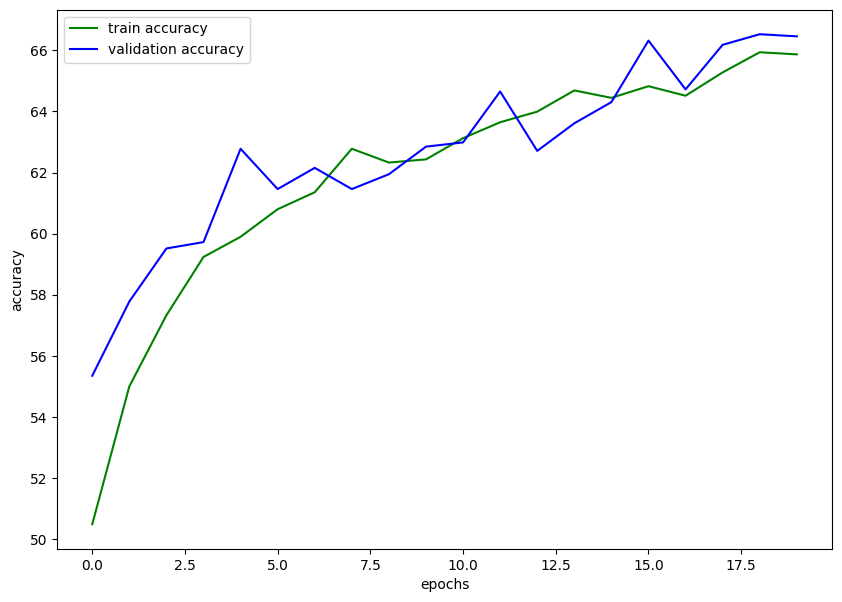

FOLD :  1
Epoch: 0 Loss: 1.3098652117782168 Acc: 51.354166666666664
[Test #1] Loss: 0.0390 Acc: 53.1944% 
Epoch: 1 Loss: 1.168389270040724 Acc: 56.458333333333336
[Test #2] Loss: 0.0363 Acc: 55.6250% 
Epoch: 2 Loss: 1.118673759036594 Acc: 57.986111111111114
[Test #3] Loss: 0.0352 Acc: 57.9861% 
Epoch: 3 Loss: 1.0925926645596822 Acc: 59.96527777777778
[Test #4] Loss: 0.0350 Acc: 58.6111% 
Epoch: 4 Loss: 1.038878255420261 Acc: 61.145833333333336
[Test #5] Loss: 0.0335 Acc: 60.4861% 
Epoch: 5 Loss: 1.0379561682542164 Acc: 61.80555555555556
[Test #6] Loss: 0.0331 Acc: 60.0000% 
Epoch: 6 Loss: 1.0164984610345629 Acc: 62.291666666666664
[Test #7] Loss: 0.0334 Acc: 60.4167% 
Epoch: 7 Loss: 1.0137275523609586 Acc: 63.05555555555556
[Test #8] Loss: 0.0333 Acc: 61.1806% 
Epoch: 8 Loss: 0.9900451759497325 Acc: 63.33333333333333
[Test #9] Loss: 0.0325 Acc: 62.3611% 
Epoch: 9 Loss: 0.968123765124215 Acc: 64.02777777777779
[Test #10] Loss: 0.0328 Acc: 61.3889% 
Epoch: 10 Loss: 0.9751210126611921 Acc

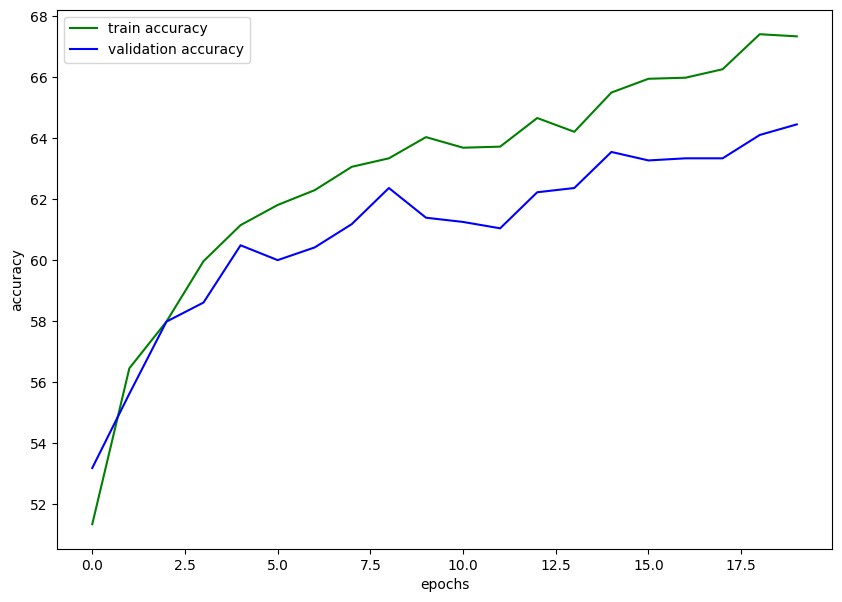

FOLD :  2
Epoch: 0 Loss: 1.2807962165938482 Acc: 52.708333333333336
[Test #1] Loss: 0.0375 Acc: 55.1389% 
Epoch: 1 Loss: 1.1593894945250618 Acc: 57.048611111111114
[Test #2] Loss: 0.0366 Acc: 57.1528% 
Epoch: 2 Loss: 1.1108595616287655 Acc: 58.88888888888889
[Test #3] Loss: 0.0338 Acc: 61.1111% 
Epoch: 3 Loss: 1.0765080703629388 Acc: 60.86805555555556
[Test #4] Loss: 0.0333 Acc: 60.2778% 
Epoch: 4 Loss: 1.0466118468178642 Acc: 61.42361111111111
[Test #5] Loss: 0.0329 Acc: 61.1806% 
Epoch: 5 Loss: 1.0576726953188578 Acc: 60.555555555555564
[Test #6] Loss: 0.0330 Acc: 61.1111% 
Epoch: 6 Loss: 1.014270868566301 Acc: 62.18750000000001
[Test #7] Loss: 0.0328 Acc: 61.1111% 
Epoch: 7 Loss: 0.9978665808836619 Acc: 63.125
[Test #8] Loss: 0.0330 Acc: 61.3194% 
Epoch: 8 Loss: 1.0117120643456776 Acc: 61.63194444444444
[Test #9] Loss: 0.0327 Acc: 62.9167% 
Epoch: 9 Loss: 1.0024028016461266 Acc: 62.81250000000001
[Test #10] Loss: 0.0316 Acc: 62.5000% 
Epoch: 10 Loss: 0.9720545732312732 Acc: 63.81944

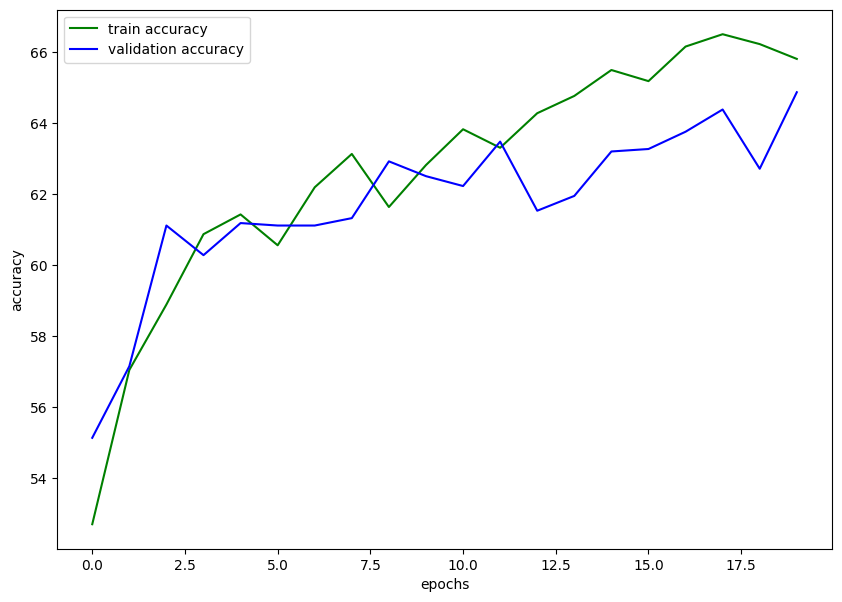

Test_Accuracy : 68.05555555555556
Confusion Matrix on the test set
[[ 69  94   0  29  12]
 [ 18 503   0  21  10]
 [  5  18   2   4   7]
 [  7  43   1  76   5]
 [ 10  43   0  18  85]]


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split

from torchvision import models




# Define Stratified K-Fold cross-validation
skf = KFold(n_splits=3, shuffle=True)

# Get the lists for printing the confusion matrix

true_labels = []
predicted_labels = []

# Now we Load the custom Training And Testing Data

train_data = CustomDataset(train_path , transform = transforms_train)
test_data = CustomDataset(test_path , transform = transforms_test)

indices = list(range(len(train_data)))

# Now create the testloader for test_data

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4)

for fold, (train_index, val_index) in enumerate(skf.split(indices, [train_data.label[idx] for idx in indices])):
  val_true_labels = []
  val_predicted_labels = []

  print("FOLD : " , fold)
  train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
  val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

  # Create data loaders for training and validation
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler, num_workers=4)
  val_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=val_sampler, num_workers=4)



  # Since Resnet50 has 1000 out_features we will need to change it because our model has 1000 features.

  model = CustomCNN()
  model = model.to(device)

  # Define the loss function

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

  num_epochs = 20

  train_loss=[]
  train_accuracy=[]
  test_loss=[]
  test_accuracy=[]

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0
      running_corrects = 0
      total_train = 0

      # Now we load a Batch of Images

      for i , (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()
          outputs = model(images)

          _ , preds = torch.max(outputs , 1)


          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          running_corrects += torch.sum(preds == labels.data)
          total_train += labels.size(0)

      epoch_loss = running_loss / total_train
      epoch_acc = running_corrects.double() / total_train * 100

      print('Epoch: {} Loss: {} Acc: {}'.format(epoch, epoch_loss, epoch_acc))

      train_loss.append(epoch_loss)
      train_accuracy.append(epoch_acc)

      model.eval()
      with torch.no_grad():
        running_loss = 0
        running_corrects = 0
        total_val = 0

        for i , (inputs , labels) in enumerate(val_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model.forward(inputs)

          _ , preds = torch.max(outputs , 1)

          loss = criterion(outputs , labels)

          running_loss += loss.item()
          total_val += labels.size(0)
          running_corrects += torch.sum(preds == labels.data).item()
          val_true_labels.extend(labels.cpu().numpy())
          val_predicted_labels.extend(preds.cpu().numpy())

        epoch_loss = running_loss / len(val_sampler)
        epoch_acc = running_corrects / total_val *100

        # Append result

        test_loss.append(epoch_loss)
        test_accuracy.append(epoch_acc)

        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% '.format(epoch+1, epoch_loss, epoch_acc))


  print('Confusion Matrix on the validation set Fold :' , fold)
  print(confusion_matrix(val_true_labels, val_predicted_labels))

  plt.figure(figsize=(10, 7))
  train_accuracy_tensor = torch.tensor(train_accuracy).cpu()
  test_accuracy_tensor = torch.tensor(test_accuracy).cpu()

  plt.plot(train_accuracy_tensor, color='green', label='train accuracy')
  plt.plot(test_accuracy_tensor, color='blue', label='validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

with torch.no_grad():
  running_corrects = 0
  total_test = 0

  for i , (inputs , labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model.forward(inputs)
    _ , preds = torch.max(outputs , 1)
    running_corrects += torch.sum(preds == labels.data).item()
    total_test += labels.size(0)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

  epoch_acc = running_corrects / total_test *100

  print("Test_Accuracy :" , epoch_acc)

  print('Confusion Matrix on the test set')
  print(confusion_matrix(true_labels, predicted_labels))











In [ ]:
import torch

# Assuming your model is named 'model'
torch.save(model.state_dict(), 'CustomCNN5ClassClassification.pth')

Total convolution layers: 6


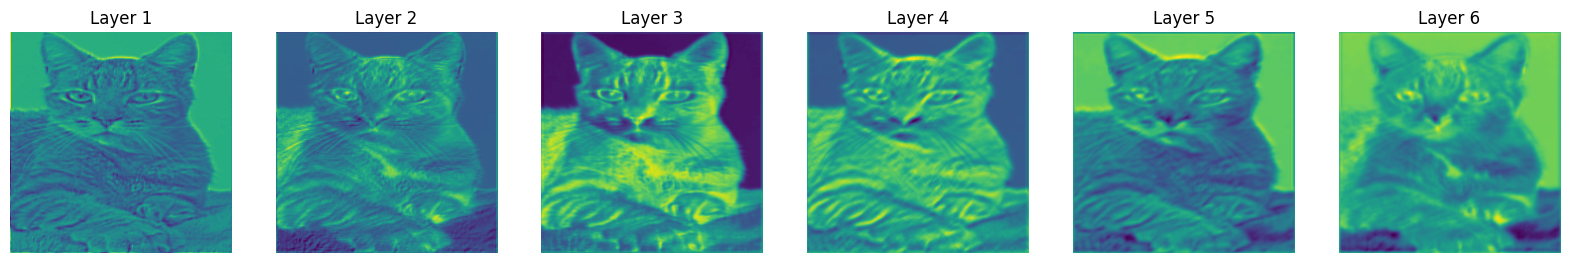

In [ ]:
from torchvision import transforms

# Define image transformations
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p = 0.5), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

# Function to visualize feature maps
# Function to visualize feature maps
def nn_layer_visual(image, model, model_path, image_transforms):
    # Load model weights
    model.load_state_dict(torch.load(model_path))

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Apply transformations to the image
    image = image_transforms(image).unsqueeze(0).to(device)  # Convert image to batch of size 1

    # Store convolutional layers
    conv_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv2d)]
    num_conv_layers = len(conv_layers)

    print(f"Total convolution layers: {num_conv_layers}")

    # Ensure the input tensor is on the same device as the model
    image = image.to(device)

    # Store the output of each convolutional layer
    outputs = []
    for layer in conv_layers:
        image = layer(image)
        outputs.append(image)



    # Visualize the feature maps
    # Visualize the feature maps
    fig, axes = plt.subplots(1, num_conv_layers, figsize=(20, 5))
    for i, feature_map in enumerate(outputs):

        ax = axes[i] if num_conv_layers > 1 else axes
        #print(feature_map.squeeze(0).cpu().detach().numpy()[0])
        ax.imshow(feature_map.squeeze(0).cpu().detach().numpy()[0])
        ax.set_title(f"Layer {i+1}")
        ax.axis('off')
    #plt.show()




# Example usage
image_path = "//content//drive//My Drive//DeepLearningCollab//Animal//train//cat//0b54dde5f5.jpg"
image = Image.open(image_path)
model = CustomCNN()
nn_layer_visual(image, model, 'CustomCNN5ClassClassification.pth', transforms_train)
